Notebook by:
* Lorenzo Pannacci 1948926
* Rebecca Conti 1896168
* INSERT YOUR NAME HERE

# Startup

In [9]:
######################
# LIBRARIES DOWNLOAD #
######################

install_packages = False
if install_packages:
  %pip install numpy pandas pyspark matplotlib networkx

In [10]:
####################
# LIBRARIES IMPORT #
####################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import pickle
import os
from pyspark import SparkContext, SparkConf
from importlib import reload
from scipy import stats

# set spark environment
os.environ['PYSPARK_PYTHON'] = r"D:\File\Anaconda\pythonw.exe"
os.environ['PYSPARK_DRIVER_PYTHON'] = r"D:\File\Anaconda\pythonw.exe"

In [18]:
########################
# LOCAL MODULES IMPORT #
########################

import functionality
import visualization

In [123]:
# libraries reloading

functionality = reload(functionality)
visualization = reload(visualization)

# 1. Data

In this homework, you will work on a dataset that contains information about a group of papers and their citation relationships. You can find and download the dataset [here](https://www.kaggle.com/datasets/mathurinache/citation-network-dataset)

### Graphs setup 
Based on the available data, you will create two graphs to model our relationships as follows: 

1. __Citation graph__: This graph should represent the paper's citation relationships. We want this graph to be unweighted and directed. The citation should represent the citation given from one paper to another. For example, if paper A has cited paper B, we should expect an edge from node A to B.

2. __Collaboration graph__: This graph should represent the collaborations of the paper's authors. This graph should be weighted and undirected. Consider an appropriate weighting scheme for your edges to make your graph weighted.

### Data pre-processing

The dataset is quite large and may not fit in your memory when you try constructing your graph. So, what is the solution? You should focus your investigation on a subgraph. You can work on the most connected component in the graph. However, you must first construct and analyze the connections to identify the connected components. 

As a result, you will attempt to approximate that most connected component by performing the following steps: 
1. Identify the __top 10,000__ papers with the <ins>highest number of citations</ins>.
2. Then the __nodes__ of your graphs would be as follows:

   __Citation graph__: you can consider each of the papers as your nodes

   __Collaboration graph__: the authors of these papers would be your nodes
    
3. For the __edges__ of the two graphs, you would have the following cases:
   
   __Citation graph__: only consider the citation relationship between these 10,000 papers and ignore the rest.
   
   __Collaboration graph__: only consider the collaborations between the authors of these 10,000 papers and ignore the rest. 

---

Before building the two graphs, we need to preprocess the dataset. The whole .json file has a size on disk of about 12 GB, it is too big and it does not fit into the RAM all at once. Moreover there are some problems with the .json file format. We deal with this problems using the bash script `bash_script.sh` under the `scripts/` folder. It performs the following operations:

- Split the big dataset into 24 files of 200k lineas each
- Fix the json format

The file has to be executed manually outside the notebook.

You can read more details in the comments inside the script.

---

In [3]:
# variable to launch the preprocessing and graph building procedure

# change to True to launch it
preprocess_and_build = True

---

Here we load the first split of the dataset to see how it looks like:

---

In [6]:
if preprocess_and_build == True:

  df_tmp = pd.read_json(r'dataset/split_aa', lines=True)
  df_tmp.info()
  print(df_tmp.head(3))

  # remove df_tmp from memory to free up space
  del df_tmp;

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199999 entries, 0 to 199998
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                199999 non-null  int64 
 1   authors           199999 non-null  object
 2   title             199999 non-null  object
 3   year              199999 non-null  int64 
 4   n_citation        199999 non-null  int64 
 5   page_start        199999 non-null  object
 6   page_end          199999 non-null  object
 7   doc_type          199999 non-null  object
 8   publisher         199999 non-null  object
 9   volume            199999 non-null  object
 10  issue             199999 non-null  object
 11  doi               199999 non-null  object
 12  references        109640 non-null  object
 13  indexed_abstract  114099 non-null  object
 14  fos               197869 non-null  object
 15  venue             199999 non-null  object
 16  alias_ids         618 non-null     obj

Our stragegy to build the **citation graph** is the following:

> 1. Read the columns `id`, `n_citations`, `references` from the split and merge them. <br>
> This is the smallest number of features that we need to build the Citation graph as it contains the papers IDs (that will become the nodes of the graph), the number of citations (we will need to sort and choose the 10k papers with the highest citation number) and the references to other articles, that will become the edges of the graph.
> 
> 2. Add a column `split_name` that contains the name of the file  split that contains each row (below we want to read again those file and to load all the information regarding the papers in the citation graph).
>
> 3. Sort the dataframe by `n_citations` in decreasing value. We will keep only the first 10k rows.
>
> 4. Build a list of all the edges in the citation graph using the `id` and the `references` columns.
>
> 5. Create the `Citation graph` where each node is the id of a paper. Later we will add the paper info as attributes. 
>
> 6. Read again the file splits to save all the information about the nodes in the citation graph. <br>
> We do it in an optimized way, reading the file in chunks and saving only the relevant rows. <br>
> Then we can add all the paper info to the graph.
>
>7. Save the finished citation graph in `graphs/citation-graph.pickle`.

The final citation graph will have 10k nodes and a maximal connected component with 9305 nodes.

In [7]:
# here we create a new dataset that contains for every paper ONLY the id, n_citations, references columns
# and we add the split_name column to each row

small_csv_exist = os.path.exists("small_dataset.csv")

if preprocess_and_build == True and not small_csv_exist:
    # read the filepaths of the split files
    # the split file must be in the "dataset/" folder
    filepaths = [f for f in os.listdir("dataset/") if os.path.isfile(os.path.join("dataset/", f))]
    filepaths.sort()

    # select the desired columns to keep
    # split_name is the name of the split file where the row comes from
    cols = ['id', 'n_citation', 'references', 'split_name']

    # an empty dataframe to store the data
    df_small = pd.DataFrame(columns = cols)
    
    # setting up the progress bar
    pbar = tqdm(total = len(filepaths))

    # read all the split and save only the relevant columns
    for filepath in filepaths:
        
        # we read each split in chunks, to reduce memory consumption
        chunks = pd.read_json("dataset/" + filepath, lines=True, chunksize=50000, orient="records")
        for chk in chunks:
            try:
                # add the split_name column to the chunk before concatenating
                chk['split_name'] = filepath
                
                # concatenate the chunk to the dataframe
                df_small = pd.concat([df_small, chk[cols]], ignore_index=True)
                
            except Exception as e:
                print(chk)

        pbar.update(1)
    pbar.close()
        
    # set the id column as index
    df_small.set_index('id', inplace=True)


    print(f"There are {len(df_small)} papers in the whole dataset")
    
    # save the df_small dataset to file for later use
    df_small.to_csv("small_dataset.csv")
    


  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [20:51<00:00, 52.15s/it]


There are 4799999 papers in the whole dataset


In [19]:
# load the dataset from file if the file has been already created

def process_rows(row):
    if isinstance(row, str):
        # remove brackets and split
        row = row.strip('[]').split(',')

        # convert elements to int
        row = [int(i) for i in row]

    elif pd.isna(row):
        # assign an empty list for NaN
        row = []

    return row

if small_csv_exist:
  # load from csv
  df_small = pd.read_csv("small_dataset.csv", index_col='id')

  # since moving it into a csv converted the list into a string we have to take it back to a string
  df_small['references'] = df_small['references'].apply(process_rows)

### Building the Citation graph

---

Sorting the dataframe by `n_citations` in decreasing value. We will keep only the first 10k rows:

---

In [20]:
if preprocess_and_build == True:
  df_small['n_citation'] = df_small['n_citation'].astype(int)
  df_small = df_small.sort_values(by=['n_citation'], ascending=False).nlargest(10000, 'n_citation')

---

We start building the structure of the citation graph, it will be a directed and unweighted graph where a node represent a certain paper and an edge from A to B represent the fact that paper A has cited paper B.

---

In [50]:
if preprocess_and_build == True:
  # to create the graph we have to create the list of nodes and the list of edges
  # the list of nodes is immediate as is the list indices of our dataframe

  # we have to create a list containing all the edges, each edge wil be a tuple (from, to)

  exploded = df_small.references.explode()

  # converting it to a list of tuples with the index
  edges_list = list(zip(exploded.index, exploded))

  # removing the edges that have NaN values
  edges_list = list(filter(lambda x: not np.isnan(x[1]), edges_list))
  edges_list = np.array(edges_list)

  # removing the edges that point to nodes outside the subset we created
  indices = np.isin(edges_list[:, 1], df_small.index.values)
  edges_list = edges_list[indices]

In [51]:
if preprocess_and_build == True:
  # initialize an empty directed graph 
  G_citation = nx.DiGraph()
  
  # Adding the node to the graph
  G_citation.add_nodes_from(df_small.index.values)
  
  # Adding the edges to the graph
  G_citation.add_edges_from(edges_list)
  
  print(f"In the citation graph there are {len(G_citation.edges)} edges and {len(G_citation.nodes)} nodes")

In the citation graph there are 52110 edges and 10000 nodes


---

Below is a function to get the largest connected component of a graph. We also test it to find the biggest connected component of the citation graph.

---

In [52]:
def biggest_connected_component(G):
  
  # get the length of each connected component and print the maximum
  len_conn_components = [len(c) for c in sorted(nx.connected_components(G.to_undirected()), key=len, reverse=True)]
  max_len = len_conn_components[0]
  print(f"Size of the largest connected component: {max_len} nodes")
  
  # save the biggest component as a subgraph
  for c in nx.connected_components(G.to_undirected()):
    if len(c) == max_len:
      S = G.subgraph(c).copy()
      break
  
  return S

if preprocess_and_build == True:
  # Get the biggest connected component
  G_citation_biggest = biggest_connected_component(G_citation)

Size of the largest connected component: 9305 nodes


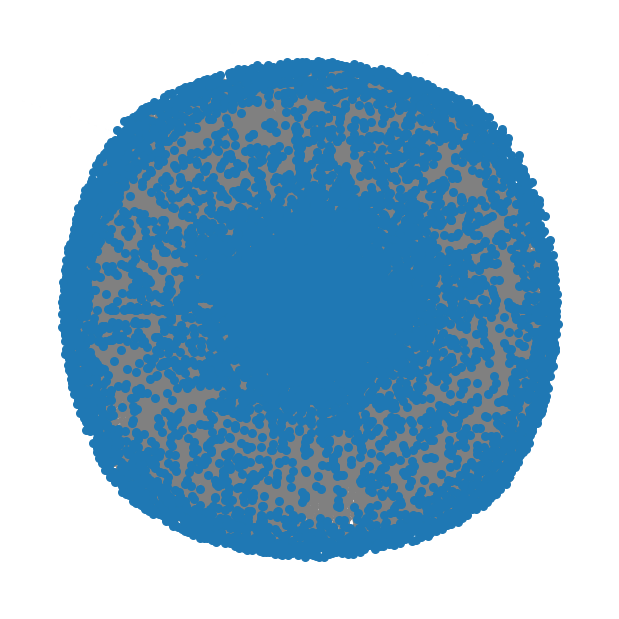

In [53]:
if preprocess_and_build == True:
  # Draw the citation graph
  plt.figure(figsize=(6,6)) 
  pos = nx.spring_layout(G_citation)
  nx.draw(G_citation, pos, with_labels=False, node_size=30,font_size=8, edge_color='gray')

---

In the end this picture is not so meaningful since there are too many nodes in the graph.

---

Now we can read again the file splits to save all the information about the nodes in the citation graph. First we create a dictionary with the split names as keys and the corresponding paper id as values. Then we read the split files again and we save only the info about the most important 10k papers.

---

In [54]:
# creating a dictionary with the split names as keys and the corresponding paper id as values

if preprocess_and_build == True:

  # first of all we create an ampty dictionary with the split names as keys
  dict_split = {key: [] for key in df_small['split_name'].unique()}

  # then we fill the dictionary with the paper ids
  for id, row in df_small.iterrows():
    dict_split[row['split_name']].append(id)
    
  # remove df_small from memory to free up space
  del df_small
    
  # now read again the file to save all the information about the nodes in the citation graph
  # we do it in an optimized way, reading the file in chunks and saving only the relevant rows

  # an empty dataframe to store the data
  df = pd.DataFrame()

  # setting up the progress bar
  pbar = tqdm(total = len(dict_split.keys()))

  for filepath in dict_split.keys():
      
    # we read each split in chunks, to reduce memory consumption
    chunks = pd.read_json("dataset/" + filepath, lines=True, chunksize=10000, orient="records")
      
    for chk in chunks:
          
      # check if all the nodes in that filepath have already been analyzed
      if dict_split[filepath] == []:
        break
          
      else:
        try:
          # save only the rows with the paper ids in the dict_split
          chk = chk[chk.id.isin(dict_split[filepath])]
                  
          # concatenate the chunk to the dataframe
          df = pd.concat([df, chk], ignore_index=True)     
                  
          # # remove the paper ids that have already been loaded
          dict_split[filepath] = [id for id in dict_split[filepath] if id not in chk.id.values]       
      
        except Exception as e:
          # print(chk)
          pass
  
    pbar.update(1)
  pbar.close()
  
  # set the id column as index
  df.set_index('id', inplace=True)
  
  # adding all the info about the nodes/papers to the graph
  for node in G_citation.nodes:
    nx.set_node_attributes(G_citation, {node: df.loc[node].to_dict()})
    
  # saving the citation graph to file
  pickle.dump(G_citation, open('graphs/citation-graph.pickle', 'wb'))

100%|██████████| 24/24 [34:45<00:00, 86.90s/it]


In [ ]:
# # Uncomment to read the citation graph from file:
# G_citation = pickle.load(open('graphs/citation-graph.pickle', 'rb'))

### Building the Collaboration graph

---

Now that we have built the citation graph we can focus on building the collaboration graph. Each node will be a certain author of the papers in the citation graph and each edge will represent if two authors have ever collaborated. This graph will be undirected and weighted. The weight from a node A to a node B (and viceversa) will be the following:
$$weight(A, B) = \frac{1}{\text{number of collaborations between author A and B}}$$

**We want authors that collaborated more times to have a smaller weight**, and authors that collaborated only one time to have the maximum value of the edge 1. In this way computing a shortest path from a node A to a node B will means that those **authors that have collaborated more will have the highest chance of collaborating again.** This is because finding the shortest path is a problem about minimizing the path cost. 

Our strategy to build the **collaboration graph** will be as follow:
> 1. Get the `id` of the 10k most important papers from the citation graph nodes.
>
> 2. Create an authors list with all the author information. The Collaboration Graph will have as nodes the id of the authors. We will add as nodes attributes the info about the author.
>
> 3. Each edge will represent a collaboration between the two authors, i.e. nodes. Before adding the edges we need to create a DataFrame with all the possible combinations of authors and compute the number of times that they have collaborated. The dataframe will be symmetric. Then we will add the edges to the collaboration graph with the relative weights (explained in the formula above).
> 
> 4. Save the finished collaboration graph in `graphs/collaboration-graph.pickle`.

---

In [55]:
if preprocess_and_build == True:
  # rebuild the dataframe from the graph
  df = pd.DataFrame.from_dict(dict(G_citation.nodes(data=True)), orient='index')
  
  # first of all we create a dictionary with all the authors of the citation graph
  # the key is the author id
  authors_list = {}

  # setting up the progress bar
  pbar = tqdm(total = df.shape[0])

  for id, paper in df.iterrows():
    for author in paper['authors']:

      if author['id'] not in authors_list.keys():
        authors_list[author['id']] = author

    pbar.update(1)
  pbar.close()
  
  # the Collaboration Graph will have as nodes the id of the authors
  G_collaboration = nx.Graph()
  G_collaboration.add_nodes_from(authors_list.keys())

  # then we will append as attributes the information about the authors
  # adding the authors information as attributes
  for id,  info in authors_list.items():
    nx.set_node_attributes(G_collaboration, {id: info})

100%|██████████| 10000/10000 [00:00<00:00, 17921.07it/s]


---

Before adding the edges we need to create a DataFrame with all the possible combinations of authors and compute the number of times that they have collaborated:

---

In [56]:
if preprocess_and_build == True:

  # we initialize the DataFrame with all zeros
  df_collaboration = pd.DataFrame(data = 0, columns = authors_list.keys(), index = authors_list.keys(), dtype = int)

  # now we fill the colaboration dataframe with the number of collaborations; the matrix will be symmetric
  df_collaboration = pd.DataFrame(data = 0, columns = authors_list.keys(), index = authors_list.keys(), dtype = int)

  # setting up the progress bar
  pbar = tqdm(total = df.shape[0])

  for id, paper in df.iterrows():
    for author in paper['authors']:
      for coauthor in paper['authors']:

        if author['id'] != coauthor['id']:
          df_collaboration.loc[author['id'], coauthor['id']] += 1
  
    pbar.update(1)
  pbar.close()

  # add the edges to the graphs with the relative weights

  # setting up the progress bar
  pbar = tqdm(total = df_collaboration.shape[0])

  for id, row in df_collaboration.iterrows():
    for col, value in row.items():
      if value != 0:
        # the weights of the edges will be one divided by the number of times two authors have collaborated
        G_collaboration.add_edge(id, col, weight = 1/value)
        
    pbar.update(1)
  pbar.close()

  # save the collaboration graph to file
  pickle.dump(G_collaboration, open('graphs/collaboration-graph.pickle', 'wb'))
  
  # # Uncomment to read the collaboration graph from file:
  # G_collaboration = pickle.load(open('graphs/collaboration-graph.pickle', 'rb'))

100%|██████████| 21099/21099 [02:04<00:00, 169.55it/s]


---

We now elaborate some statistics about the collaboration graph, such that the number of total collaborations:

---

In [58]:
if preprocess_and_build == True:
  # number of total collaborations
  # since the matrix is simmetrical and the collaboration is a bidirectional relationship
  # we have to divide by 2
  tot_collab = df_collaboration[df_collaboration > 0].count().sum() // 2
  print(f"There are {tot_collab} collaborations in the graph")

There are 121378 collaborations in the graph


---

Now we want to know how many nodes has the biggest connected component of the collaboration graph.

---

In [59]:
if preprocess_and_build == True:
  # get the biggest connected component
  G_collab_biggest = biggest_connected_component(G_collaboration)

Size of the largest connected component: 9231 nodes


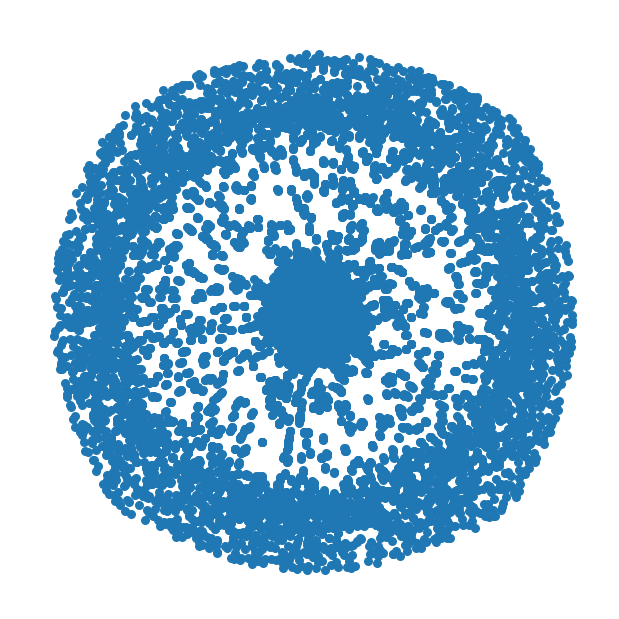

In [60]:
if preprocess_and_build == True:
  # draw the collaboration graph
  plt.figure(figsize=(6,6)) 
  pos = nx.spring_layout(G_collaboration)
  nx.draw(G_collaboration, pos, with_labels=False, node_size=30,font_size=8, edge_color='gray')

---

In the end this picture is not so meaningful since there are too many nodes in the graph.

---

# 2. Controlling system

Please keep the following in mind for both the backend and frontend components. The plan is to put in place a control system. You will provide the user with a menu from which he can select different functionalities. The user should be able to select from one of five different functionalities that you will implement in the following two sections. We want to have such a system so that the user can query different functionalities that he is interested in.

Your function should be designed in such a way that it provides the most flexibility to the user. For example, when the user selects functionality 1, which provides some high-level information about the graph, you can allow him to pass an argument indicating which of the two types of graphs he wants to be analyzed (That is why the name of the graph is one of the arguments in the first functionality).

You will implement the functionalities in the Backend section. The Frontend section primarily discusses the menu that you must provide to the user, as well as the expected results that should be displayed to the user after selecting each of the functionalities.

---

We load the Graphs from the previously created files, this will be useful to test the functionalities as we build them.

---

In [13]:
G_citation = pickle.load(open('graphs/citation-graph.pickle', 'rb'))
G_collaboration = pickle.load(open('graphs/collaboration-graph.pickle', 'rb'))

## 2.1. Backend Implementation

This section describes what each of the functionalities should be.

### Functionality 1 - Graph's features

<!-- This function should examine a graph and report on some of its features. The input and report that this function should produce are shown below. -->

Input:
* The graph
* The name of the graph

Output:
* The number of the nodes in the graph
* The number of the edges in the graph
* The graph density
* The graph degree distribution
* The average degree of the graph
* The graph hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
* Whether the graph is dense or sparse


---

**All the functions that we build on the backend part of the project are saved on a file called functionality.py**

For the first functionality we have to show some graph's features, so we build a function that take as input the graph data structure and his name and output all the required features as a dictionary.

- **The number of the nodes in the graph**: saved in the field `Number of Nodes`; this is just the length of the nodes list.
- **The number of the edges in the graph**: saved in the field `Number of Edges`; this is just the length of the edges list.
- **The graph density**: saved in the field `Graph density`; it represent how many edges the graph has in respect with the maximum number of edges it could have (the max is when every node is connected with every other node). We compute the density of the graph using networkx's density function.
- **The graph degree distribution**: saved in the field `Graph Degree Distribution`; it constructs a dictionary representing the degree distribution of nodes in the graph.
- **The average degree of the graph**: saved in the field `Average Degree`; this is just two times the number of edges divided by the number of nodes.
- **The graph hubs**: saved in the field `Graph Hubs`; hubs are nodes having a degree higher than the 95th percentile of the degree distribution. We determine the degree of the 95th percentile and find all the nodes whose degree is higher than this value.
- **Whether the graph is dense or sparse**: saved in the field `Graph Type`; based on the graph's density it categorizes the graph as either "Dense" or "Sparse". We took as threshold density > 0.5 to be dense and sparse otherwise.

---

In [16]:
# check 'functionality.py' to see the code of the function
# the example is difficult to read as for now we just print the output dictionary
# it will be more readable in the visualization part

citation_features = functionality.graph_features(G_citation, "Citation Graph")

print("Graph's features for the Citation Graph:")
print(citation_features)

collaboration_features = functionality.graph_features(G_collaboration, "Collaboration Graph")

print("\nGraph's features for the Collaboration Graph:")
print(collaboration_features)

Graph's features for the Citation Graph:
{'Graph Name': 'Citation Graph', 'Number of Nodes': 10000, 'Number of Edges': 52110, 'Graph Density': 0.0005211521152115212, 'Graph In-Degree Distribution': {0: 1931, 1: 1519, 2: 1261, 3: 929, 4: 740, 5: 634, 6: 524, 7: 383, 8: 286, 9: 252, 10: 232, 11: 188, 12: 151, 13: 112, 14: 104, 15: 103, 16: 66, 17: 72, 18: 48, 19: 41, 20: 43, 21: 39, 22: 30, 23: 23, 24: 24, 25: 15, 26: 21, 27: 19, 28: 22, 29: 14, 30: 12, 31: 6, 32: 6, 33: 6, 34: 7, 35: 11, 36: 7, 37: 6, 38: 10, 39: 4, 40: 7, 42: 4, 43: 11, 44: 4, 45: 3, 46: 3, 47: 5, 48: 3, 49: 1, 51: 2, 52: 1, 53: 4, 54: 3, 55: 3, 56: 2, 57: 1, 58: 2, 59: 3, 60: 1, 61: 3, 62: 3, 63: 2, 64: 3, 65: 1, 66: 2, 67: 3, 68: 3, 69: 1, 70: 2, 71: 1, 74: 1, 76: 2, 78: 1, 87: 1, 89: 1, 94: 1, 95: 1, 103: 1, 117: 1, 120: 1, 131: 1}, 'Graph Out-Degree Distribution': {0: 2107, 1: 1089, 2: 1049, 3: 858, 4: 777, 5: 659, 6: 567, 7: 486, 8: 392, 9: 311, 10: 277, 11: 236, 12: 193, 13: 151, 14: 111, 15: 112, 16: 105, 17: 76

---

The collaboration graph appears to be significantly larger, containing 21.099 nodes, which is more than double the size of the citation graph, which has exactly 10.000 nodes. The ratio between the number of nodes and edges is similar, given that the two graphs shows near identical densities, both around 0.0005. The two graphs are similar also in terms of the average degree, with the citation graph having an average degree of 10.4 and the collaboration graph of 11.5.

---

### Functionality 2 - Nodes' contribution 
Using this functionality, you will identify the papers/authors who have significantly contributed to this field of study. For this analysis, focusing solely on the number of citations for the paper or the number of collaborations of the authors can be misleading. You will examine this using various centrality measurements.

Input:
- The graph
- A node of the graph (paper/author)
- The name of the graph

Output: 
- The centrality of the node, calculated based on the following centrality measurements:
   - [Betweeness](https://www.tandfonline.com/doi/abs/10.1080/0022250X.2001.9990249)
   - [PageRank](https://courses.cs.washington.edu/courses/cse373/17au/project3/project3-3.html)
   - [ClosenessCentrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality)
   - DegreeCentrality

---

This function compute different measures of centrality, using the package `networkx`, starting from a given node and his graph, then returns the required outputs in a dictionary.
The measures of centrality that we used are:

- **Betweenness Centrality**: Measures the importance of a node based on the number of shortest paths that pass through it.
- **PageRank**: Computes the PageRank score for the node. PageRank evaluates the importance of a node in a network based on its connections.
- **Closeness Centrality**: Evaluates how centrally a node is located by measuring the average shortest path length to other nodes.
- **Degree Centrality**: Calculates the degree centrality of the node, which is the fraction of nodes it is connected to.

---

In [ ]:
# check 'functionality.py' to see the code of the function
# the example is difficult to read as for now we just print the output dictionary
# it will be more readable in the visualization part

centrality_data = functionality.calculate_centralities(G_citation, 'Citation_graph', 2041404167)
print(centrality_data)

{'Graph Name': 'Citation_graph', 'Node': 2041404167, 'Betweenness': 0.0, 'PageRank': 0.004618610309009709, 'Closeness Centrality': 0.11834699701084848, 'Degree Centrality': 0.009500950095009501}


---

We got some scores, but to really understand the meaning of those informations we have to confront them with the scores other nodes got. We can understand how high those scores are with respect to the other nodes using searching the percentile value of the score over the scores of all the nodes in the graph.

---

In [ ]:
# calculate the scores for all the nodes

betweenness = list(nx.betweenness_centrality(G_citation).values())
pagerank = list(nx.pagerank(G_citation).values())
closeness = list(nx.closeness_centrality(G_citation).values())
degree = list(nx.degree_centrality(G_citation).values())

In [ ]:
print("Percentile for Betweeness centrality:", stats.percentileofscore(betweenness, centrality_data["Betweenness"]))
print("Percentile for PageRank:", stats.percentileofscore(pagerank, centrality_data["PageRank"]))
print("Percentile for Closeness centrality:", stats.percentileofscore(closeness, centrality_data["Closeness Centrality"]))
print("Percentile for Degree centrality:", stats.percentileofscore(degree, centrality_data["Degree Centrality"]))

Percentile for Betweeness centrality: 18.065
Percentile for PageRank: 100.0
Percentile for Closeness centrality: 99.99000000000001
Percentile for Degree centrality: 99.94


---

For the Citation graph we decide to analyze of the node `2041404167`.

* Its Betweenness centrality value is measured to be 0.0; this value is the minimum one node can get (actually it seems that 18% of the nodes got it) and suggests that this node do not serve as a bridge or intermediary for shortest paths within the graph.
* Its PageRank score is around 0.0046, given that the graph is composed of 10.000 nodes the average value of PageRank would be 0.0001, therefore this page seems to have a great importance over the graph (it has a value 46 greater than the mean). Thanks to the percentile we understand that this node has the highest PageRank score of the whole graph!
* Its Closeness centrality value is around 0.118, by watching the percentile we understand that this is also a very high value, but not the highest of the whole graph.
* Its Degree centraility is around 0.0095, this value is also one of the highest of the whole graph.

In conclusion from those informations we can understand that this node play a very important role in the Citation graph, the only metric that's not particularly high is the Betweeness centrality, meaning that this node is not used frequently in creating shortest paths between other nodes.

---

We now do the same with the Collaboration graph:

---

In [ ]:
# check 'functionality.py' to see the code of the function
# the example is difficult to read as for now we just print the output dictionary
# it will be more readable in the visualization part

centrality_data_col = functionality.calculate_centralities(G_collaboration, 'Collaboration_graph', 1445484688)
print(centrality_data_col)

{'Graph Name': 'Collaboration_graph', 'Node': 1445484688, 'Betweenness': 0.0031310684981378034, 'PageRank': 0.00018784450451083616, 'Closeness Centrality': 0.045769415852436116, 'Degree Centrality': 0.005166366480235093}


---

And as before we calculate the percentile of the scores with respect with the scores of the other nodes:

---

In [ ]:
# calculate the scores for all the nodes

betweenness = list(nx.betweenness_centrality(G_collaboration).values())
pagerank = list(nx.pagerank(G_collaboration).values())
closeness = list(nx.closeness_centrality(G_collaboration).values())
degree = list(nx.degree_centrality(G_collaboration).values())

In [ ]:
print("Percentile for Betweeness centrality:", stats.percentileofscore(betweenness, centrality_data["Betweenness"]))
print("Percentile for PageRank:", stats.percentileofscore(pagerank, centrality_data["PageRank"]))
print("Percentile for Closeness centrality:", stats.percentileofscore(closeness, centrality_data["Closeness Centrality"]))
print("Percentile for Degree centrality:", stats.percentileofscore(degree, centrality_data["Degree Centrality"]))

Percentile for Betweeness centrality: 41.12043224797384
Percentile for PageRank: 100.0
Percentile for Closeness centrality: 100.0
Percentile for Degree centrality: 98.7629745485568


---

Here we analyze of the node `1445484688` of the Collaboration graph.

* The Betweenness centrality is measured to be 0.003. This non-zero value suggests that differently from the node in the previous example this node plays a role in the shortest paths between other nodes, even if with the percentile we understand that its role is not central in that regard.
* The other three scores are as for the previous node extremely high. Both Pagerank and Closeness centrality percentile are at 100%, meaning that this node has the highest value of the whole graph for those measures while the Degree centrality is high but not at the maximum value. The PageRank score is only around 4 times higher than the mean, meaning that in this case the PageRank score seems to be more evenly spread between the nodes. This is very interesting given that we have previously observed that the Graph density is very similar between the two graphs and lead us to think that the edges for the Collaboration Graph are spread more uniformly than those of the Citation graph.

In conclusion, as before the node taken into exam plays a very important role over the graph and it is even used in the construction of shortest paths between nodes.

---

### Functionality 3 - Shortest ordered walk  

Input:  
- The graph data 
- A sequence of authors\_a = [a\_2, ..., a\_{n-1}]
- Initial node a\_1 and an end node a\_n
- $N$: denoting the top $N$ authors whose data should be considered
 
Output: 
- The shortest walk of collaborations you need to read to get from author a\_1 to author a\_n and the papers you need to cross to realize this walk.
 
Considerations: 
For this functionality, you must implement an algorithm that returns the shortest __walk__ that goes from node a\_j to a\_n, which visits **in order** the nodes in _a_. The choice of a\_j and a\_n can be made randomly (or if it improves the performance of the algorithm, you can also define it in any other way) 

__Important Notes:__
- This algorithm should be run only on the collaboration graph.
- The algorithm needs to handle the case that the graph is not connected. Thus, only some nodes in _a_ are reachable from a\_1. In such a scenario, it is enough to let the program give in the output the string "There is no such path."
- Since we are dealing with walks, you can pass on the same node _a\_i_ more than once, but you must preserve order. It means you can go back to any author node any time you want, assuming that the order in which you visit the required nodes is still the same.
- Once you completed your implementation, ask chatGPT for a different one leveraging another approach in solving the shortest path and prove whether this implementation is correct. 


To do this functionality we need a list of authors so we start printing the list of all the authors and then we take only the top 1000 concenìrning the centrality degree.

In [ ]:
list_of_authors = list(G_collaboration.nodes())
print(list_of_authors)

[2247248564, 2102678951, 2252586558, 2104328312, 2569376642, 2102544963, 1990110535, 2895256545, 2168176072, 2022407533, 2427477170, 2134830209, 2596317628, 1445484688, 2150011549, 2120996014, 2175835430, 1208012566, 185284988, 665787499, 2298051088, 2883906439, 2915467136, 2617619131, 2229427589, 1927915088, 2305243664, 2101610026, 2170199860, 2057410742, 2034063289, 2480517110, 2289542319, 2104401652, 2435751034, 2559180283, 1932590790, 2232649233, 2874782720, 2027658599, 2007415138, 2096217197, 2105531243, 2084034853, 2146468246, 2153440608, 2316043942, 1904226804, 2140092859, 2033548732, 2033942250, 2469405535, 2055604604, 2097546270, 2977791946, 310679509, 1975899429, 2060435928, 2120464764, 1997216218, 1455141185, 2006193790, 2119315065, 2114256413, 2163117766, 2139850466, 36403351, 2063302323, 2120920645, 1171453863, 215131072, 563069026, 1983981876, 97377512, 2116333191, 2283165970, 2973420244, 2421371604, 2974816697, 2137842401, 2164292938, 2499063207, 2119543935, 2200192130, 

In [ ]:
# Calculate degree centrality for each author node
degree_centrality = nx.degree_centrality(G_collaboration)

# Sort authors based on degree centrality in descending order
sorted_authors_by_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Get top N authors based on degree centrality
top_N = 1000 # Define the value for N
top_N_authors = sorted_authors_by_degree[:top_N]


In [ ]:
#save the top authors in a list without the centrality degree value
authors=[]
for author in top_N_authors:
    authors.append(author[0])

print(authors)

[1973035492, 2034164144, 1976452423, 1984280187, 1566488673, 1524700667, 2502209291, 2114532620, 783371218, 1978529654, 2126370775, 338444495, 2240988444, 2130160582, 1896586787, 575195435, 2158371085, 2111146232, 2016350619, 60099751, 1962951839, 1130889806, 2439564882, 1992545003, 2893638541, 2916462975, 2146213778, 1971597255, 2111697827, 2626482033, 203404148, 2128406011, 2919120869, 2069507712, 2017287999, 2309978028, 1218579514, 2193977647, 2050792062, 2088169039, 2734793488, 2651026597, 2600381860, 2298018363, 2600698446, 2147711561, 2171608169, 2573427152, 1969296054, 2610365461, 2060568960, 1435048479, 1083322503, 2016157908, 2080982368, 2666655905, 2285373521, 284900582, 2019367749, 2072877244, 2501096546, 2308904679, 1936265995, 2009710689, 407941172, 2220275507, 636748954, 2538104506, 2056159655, 279330086, 2063319851, 2004854202, 2019020129, 2132577478, 2038012625, 1877528648, 2158755928, 2272323305, 295547405, 2064779820, 2694959347, 2512246175, 2154366316, 11746710, 2005

In [ ]:
from functionality import shortest_ordered_walk_v2

The function shortest_ordered_walk_v2 is designed to find the shortest ordered walk between specific nodes in a graph, considering a particular order of traversal. It verifies the presence of the starting and ending nodes, constructs an ordered sequence of nodes to traverse, checks for the existence of paths between consecutive nodes, and computes the shortest path for each pair of nodes using Dijkstra’s algorithm. The function returns either the shortest ordered walk or appropriate error messages if conditions are not met. The output suggests that the function is effective in determining the shortest path while respecting the specified order of traversal. However, the function’s effectiveness may be limited if the graph lacks paths between consecutive nodes or if the starting or ending nodes are not present.

In [ ]:
shortest_path = shortest_ordered_walk_v2(G_collaboration, authors, 1973035492, 2499302222)
print(shortest_path)

There is no such path.


In [ ]:
print(shortest_path)

There is no such path.


### Functionality 4 - Disconnecting Graphs

Input: 
- The graph data 
- authorA: a paper to which will relate sub-graph G\_a
- authorB: a paper to which will relate sub-graph G\_b
- $N$: denoting the top $N$ authors that their data should be considered

Output:
- The minimum number of edges (by considering their weights) required to disconnect the original graph in two disconnected subgraphs: G\_a and G\_b.

In [ ]:
from functionality import min_edges_to_disconnect_v2

The function `min_edges_to_disconnect_v2` calculates the minimum number of edges that need to be removed from a graph to disconnect two specified authors. It first creates a copy of the original graph and a subgraph containing only the top authors. It then removes the edges in the subgraph from the copied graph. Finally, it calculates and returns the edge connectivity between the two specified authors in the modified graph. The edge connectivity is the minimum number of edges that, if removed, would disconnect the two authors. This function can be useful in network analysis to understand the robustness of the connectivity between two nodes.

In [ ]:
min_edge=min_edges_to_disconnect_v2(G_collaboration,2502209291,783371218,authors)

In [ ]:
print(min_edge)

260


### Functionality 5 - Extracting Communities

Input: 
- The graph data 
- $N$: denoting the top $N$ papers that their data should be considered
- Paper\_1: denoting the name of one of the papers 
- Paper\_2: denoting the name of one of the papers

Output:
- The minimum number of edges that should be removed to form communities
- A list of communities, each containing a list of papers that belong to them.
- Whether the Paper\_1 and Paper\_2 belongs to the same community. 

Important Notes:  
To comprehend this functionality better, we suggest you take a good look at this [article](https://www.analyticsvidhya.com/blog/2020/04/community-detection-graphs-networks/)


In [ ]:
from functionality import extract_communities

The function `extract_communities` is designed to identify communities within a graph and determine the modularity of these communities. It first extracts data for the top authors and creates a subgraph from the original graph using this data. If the subgraph has no nodes, it returns a message indicating this. Otherwise, it detects communities within the subgraph using the Louvain method and calculates the modularity of these communities, which is the minimum number of edges that need to be removed for the communities to be separated. The function returns this modularity value, providing insight into the structure and interconnectedness of the communities within the graph.

In [ ]:
extract_communities(G_collaboration,2027658599,2883906439,authors)

'The subgraph has no nodes.'

## 2.2. Frontend Implementation 

This section describes how the final results for each functionality implemented in the backend section should be presented to the user. 

Please run __at least one query for each functionality__ in the final version of the notebook and __comment on the results__. 

### Visualization 1 - Visualize graph features 
We anticipate seeing the Functionality 1 report in Visualization 1. To be more specific, we expect you to have the following report format:

 - A table containing the following general information about the graph: 
      - Number of nodes in the graph
      - Number of the edges in the graph 
      - Density of the graph
      - Average degree of the graph
      - Whether the network is sparse or dense 
 - A table that lists the graph's hubs
 - A plot depicting the distribution of the citations received by papers (Citation graph)
 - A plot depicting the distribution of the given citations by papers (Citation graph) 
 - A plot depicting the number of collaborations of the author (Collaboration graph)

__Note:__ You can plot the features for a limited number of nodes (e.g., top 20) to improve the visualization of the plots. 

---

We decided to do the visualization using a single great matplotlib image with different subplots. We decided to limit the number of graph hubs to the top 5 to give a more balanced look to the visualization. We show the output for both graphs below:

---

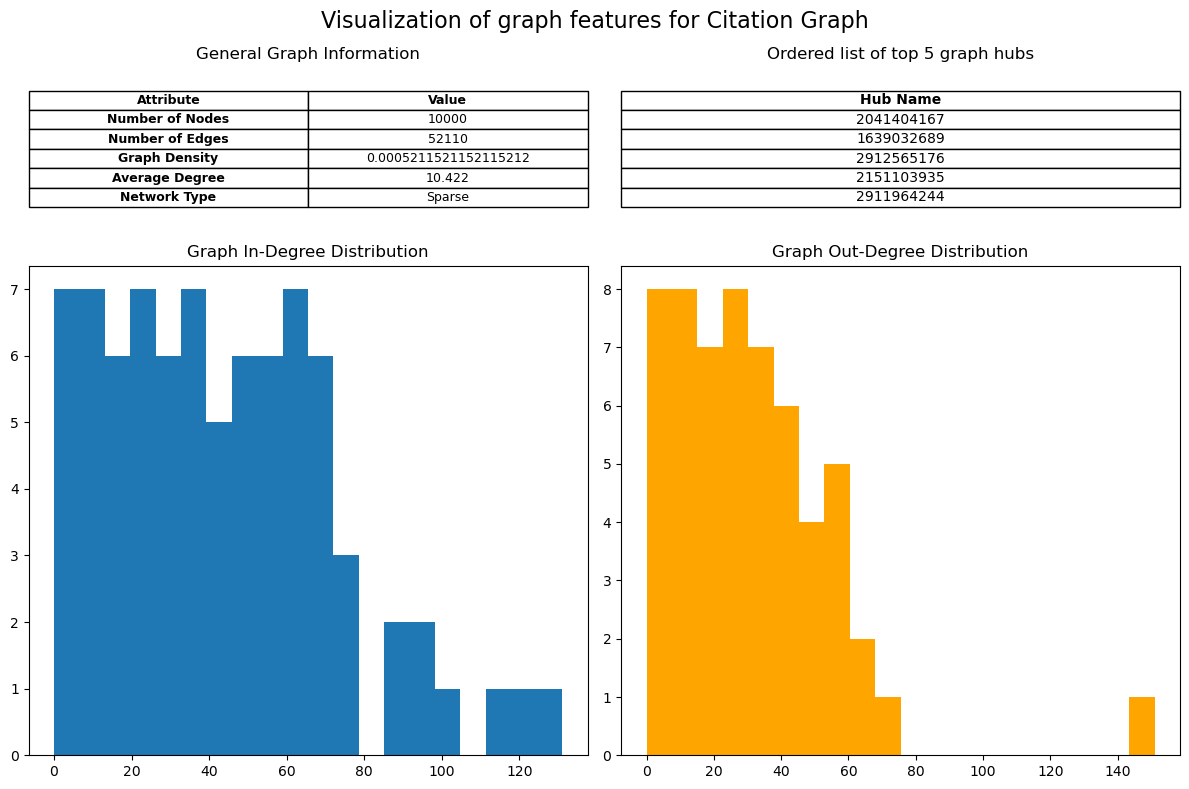

In [121]:
# check 'visualization.py' to see the code of the function

citation_features = functionality.graph_features(G_citation, "Citation Graph")
visualization.visualization_1(citation_features)

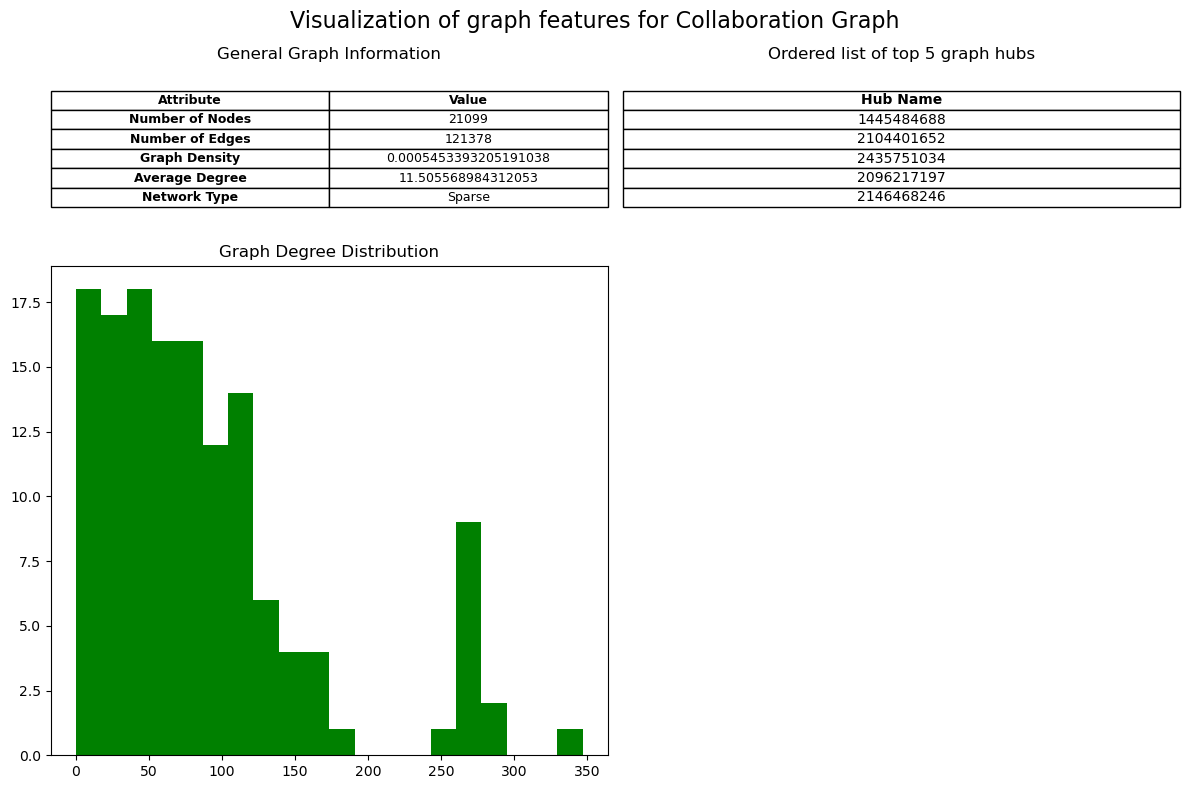

In [122]:
# check 'visualization.py' to see the code of the function

collaboration_features = functionality.graph_features(G_collaboration, "Collaboration Graph")
visualization.visualization_1(collaboration_features)

 ### Visualization 2 - Visualize the node's contribution
We anticipate seeing the Functionality 2 report in Visualization 2. To be more specific, we expect you to have the following report format:

   - A table containing the node's centrality value based on the four centrality measurements

---

This visualization is much simpler than the previous one as we have to just compile a brief table with the 4 centrality scores calculated in the functionality section of the homework. We show has examples the two node we have previously known in the functionality part.

---

In [154]:
visualization = reload(visualization)

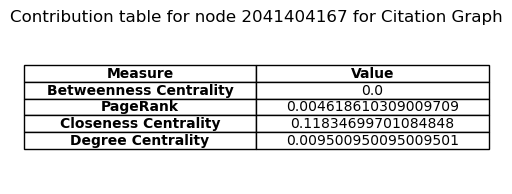

In [156]:
centrality_data_cit = functionality.calculate_centralities(G_citation, 'Citation Graph', 2041404167)
visualization.visualization_2(centrality_data_cit)

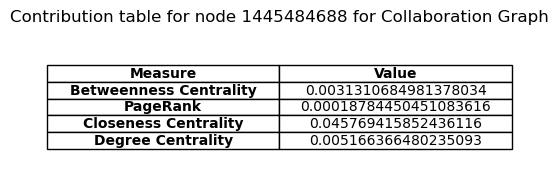

In [157]:
centrality_data_col = functionality.calculate_centralities(G_collaboration, 'Collaboration Graph', 1445484688)
visualization.visualization_2(centrality_data_col)

 ### Visualization 3 - Visualize the shortest-ordered route 
 We anticipate seeing the Functionality 3 report in Visualization 3. To be more specific, we expect you to have the following report format:
 - Print the papers needed to be crossed in the shortest walk in order 
 - Plot the graph and identify the nodes and edges that appear in the shortest walk (please put an identifier on each edge in the shortest walk to determine the order that we should have the walk)
 
 ### Visualization 4 - Visualize the disconnected graph 
 We anticipate seeing the Functionality 4 report in Visualization 4. To be more specific, we expect you to have the following report format:
 - Print the number of the links that should be disconnected 
 - Plot the original graph 
 - Plot the graph after removing the links and identify the two nodes

### Visualization 5 - Visualize the communities
We anticipate seeing the Functionality 5 report in Visualization 5. To be more specific, we expect you to have the following report format:

 - Print the number of links that should be removed to have the communities
 - A table depicting the communities and the papers that belong to each community
 - Plot the original graph 
 - Plot the graph showing the communities in the network 
 - Plot the final graph and identify the community/communities of Paper_1 and Paper_2

# 3. Bonus - PageRank on MapReduce 

__IMPORTANT:__ This is a bonus step, so it's <ins>not mandatory</ins>. You can get the maximum score without doing this. We will consider this, __only if__ the rest of the homework has been completed.

Working with big data has become increasingly important in the modern era as the volume and complexity of data generated grows. In this part, we ask you to __implement the PageRank algorithm using MapReduce paradigm__ to compute the <ins>importance of papers</ins> based on the citation relationship. 

Since a large dataset is required to fully understand the power of this paradigm, when creating the Citation graph, consider the __top 1,000,000 papers__ that have received the most citations; then, make the graph exclusively for those papers. 

__Hint:__ 
[Here](https://www.cs.utah.edu/~jeffp/teaching/cs5140-S15/cs5140/L24-MR+PR.pdf) are __two approaches__ to implement the PageRank algorithm using the MapReduce paradigm that you can use as a reference for your bonus part.

---

The first thing we have to do is to create the extended version of the Citation Graph. The approach to create it is the same as the previous one but we don't insert other info about the paper into the nodes. Note that while the request was to consider the top 1.000.000 papers we only considered the top 100.000 as the computing time was too high.

---

In [3]:
n_papers = 100000

def process_rows(row):
    if isinstance(row, str):
        # remove brackets and split
        row = row.strip('[]').split(',')

        # convert elements to int
        row = [int(i) for i in row]

    elif pd.isna(row):
        # assign an empty list for NaN
        row = []

    return row


# load from csv
df_small = pd.read_csv("small_dataset.csv", index_col='id')

# since moving it into a csv converted the list into a string we have to take it back to a string
df_small['references'] = df_small['references'].apply(process_rows)

df_small['n_citation'] = df_small['n_citation'].astype(int)
df_small = df_small.sort_values(by=['n_citation'], ascending=False).nlargest(n_papers, 'n_citation')

# to create the graph we have to create the list of nodes and the list of edges
# the list of nodes is immediate as is the list indices of our dataframe

# we have to create a list containing all the edges, each edge wil be a tuple (from, to)

exploded = df_small.references.explode()

# converting it to a list of tuples with the index
edges_list = list(zip(exploded.index, exploded))

# removing the edges that have NaN values
edges_list = list(filter(lambda x: not np.isnan(x[1]), edges_list))
edges_list = np.array(edges_list)

# removing the edges that point to nodes outside the subset we created
indices = np.isin(edges_list[:, 1], df_small.index.values)
edges_list = edges_list[indices]

# initialize an empty directed graph 
G_citation = nx.DiGraph()

# adding the node to the graph
G_citation.add_nodes_from(df_small.index.values)

# adding the edges to the graph
G_citation.add_edges_from(edges_list)

print(f"In the citation graph there are {len(G_citation.edges)} edges and {len(G_citation.nodes)} nodes")

In the citation graph there are 941705 edges and 100000 nodes


---

In [159]:
# algorithm parameters, we took the values the suggested approaches say are the usual ones
iterations = 50
beta = 0.85

# initialize SparkContext
sc = SparkContext("local", "PageRank")

# load edges as a list of tuples containing the two IDs of the nodes forming the edge
# the first element is the "source" of the edge and the second is the destination
edges = sc.parallelize(G_citation.edges())

# also load the nodes as a list
# we will need the number of nodes to calculate scores later
nodes = sc.parallelize(G_citation.nodes())
n_nodes = len(G_citation.nodes())
      
# convert the previous list into a list of tuples where the first element is a node
# and the second is a list of all the node you can reach from the starting one
# (the first element will act as "key" in the MapReduce sense)
links = edges.groupByKey().mapValues(list).cache()

# initialize PageRank scores
# since the stationary distribution is unique the starting value brings no difference in the
# outcome of the function, we decided to start with a uniform distribution for each node
page_ranks = nodes.map(lambda node: (node, 1 / n_nodes))

# we will also need empty contributions for every node to avoid the lose of keys during iterations
empty_contributions = nodes.map(lambda node: (node, 0))
      
# perform PageRank iterations
for _ in tqdm(range(iterations)):
    
    # for each iteration we have to update the probability we end up in that certain node by
    # applying the transition matrix to the current state
    # since explicitly do matrix calculations would be computationally really expensive
    # instead of doing that we can do the following

    # join for each node its score and the nodes it can reach
    contributions = links.join(page_ranks)

    # count is need to avoid the lazy behavior of Spark
    contributions.count()

    page_ranks.unpersist(blocking=True)

    # divide the current node score by the number of outgoing nodes and creating tuples
    # in this way we are computing the probability that each node give to each other node it can reach
    # with this scores we create tuples of the outgoing nodes and the score they get
    # note that each node will have a tuple for each edge that has it as its destination
    contributions = contributions.flatMap(lambda x: [(destination, x[1][1] / len(x[1][0])) for destination in x[1][0]])

    # union with empty contributions to avoid the lost of nodes without edges pointing at them
    contributions = contributions.union(empty_contributions)

    # update the scores
    # merge the previously obtained scores based on the destination (the "key")
    page_ranks = contributions.reduceByKey(lambda x, y: x + y)

    contributions.unpersist(blocking=True)

    # scale the previous score by the probability of using a real path and add
    # a constant factor to every node linked to the random teleport probability
    page_ranks = page_ranks.mapValues(lambda x: beta * x + (1 - beta) / n_nodes)

# collect final PageRank values
final_page_ranks = page_ranks.collect()

# covert into dictionary
my_pagerank = {key: value for key, value in final_page_ranks}

# stop SparkContext
sc.stop()

100%|██████████| 50/50 [5:30:34<00:00, 396.70s/it]  


---

We now want to check whether our results are correct. We can do that by comparing them with the results obtained by the PageRank method inside the networkx python library. We expect similar but not equal values, given that the results depends also on the number of iterations and the speed of convergence depends on the type of algorithm used. We can check this distance using a MSE value between the two results.

---

In [6]:
# apply networkx's PageRank algorithm on the same graph
networkx_pagerank = nx.pagerank(G_citation)

In [18]:
def l1_distance(dict1, dict2):
    squared_diff_sum = 0

    for key in dict1.keys():
        squared_diff_sum += abs(dict1.get(key) - dict2.get(key))

    mse = squared_diff_sum / len(dict1.keys())
    return mse

In [19]:
mse = l1_distance(my_pagerank, networkx_pagerank)

print(f"The L1 distance between our PageRank implementation and networkx's implementation: {mse}")

The L1 distance between our PageRank implementation and networkx's implementation: 4.925296921844481e-06


---

The distance is very low and this is a meaningful result, meaning that our scores are close to the real ones. We can try something else to check the correctness, like checking the ID of the most important paper, that is the one with the highest score.

---

In [15]:
my_highest_score = max(my_pagerank, key=my_pagerank.get)
print("Paper with highest score for our PageRank implementation:", my_highest_score)

networkx_highest_score = max(networkx_pagerank, key=networkx_pagerank.get)
print("Paper with highest score for networkx's PageRank implementation:", networkx_highest_score)

if my_highest_score == networkx_highest_score:
    print("They are the same!")
else:
    print("They are different!")

Paper with highest score for our PageRank implementation: 2041404167
Paper with highest score for networkx's PageRank implementation: 2041404167
They are the same!


---

It's important to note while we obtained the same node as the one with the highest score doing so with a lower number of iterations (we have tried with 10 iterations) yields a different outcome, while executing the algorithm for the graph of the top 10.000 papers 10 iterations were enough to get the same highest score as the networkx's implementation. This is due to the fact that a bigger graph takes more time to reach convergence.

---

# 4. Command Line Question (CLQ)

In this question, you should use any command line tools that you know to answer the following questions using the **directed** and **unweighted** graph that you have previously created: **Citation graph**: 

1. Is there any node that acts as an important "connector" between the different parts of the graph?
2. How does the degree of citation vary among the graph nodes? 
3. What is the average length of the shortest path among nodes?

__Important note:__ You may work on this question in any environment (AWS, your PC command line, Jupyter notebook, etc.), but the final script must be placed in CommandLine.sh, which must be executable. Please run the script and include a __screenshot__ of the <ins>output</ins> in the notebook for evaluation.  

---

The bash script related to this question is in the main folder of the github repository. The screenshots instead are inside the `images/` folder. The script takes as input the graph in the form of an adjacency matrix created from the graph using a python script. The script takes as argument the number of the question to which you want the answer: 1, 2 or 3.

Below are the outputs we obtained from the script with a brief comment for every section:

---

**1. Is there any node that acts as an important "connector" between the different parts of the graph?**

---
  
When talking about graphs a node that is a crucial link between parts of a graph is called hubs or bridge, so our objective is to find the hubs nodes. We've already implemented a function that calculate the hubs for a graph, so we decided to use the same definition used above: *"hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution"*, but considering only the in-degree of the nodes given that also by considering the second question it seems to be the focus factor of the analysis in this section of the homework. So first of all we find the in-degree of each node and then we take only the nodes that have in-degree > 95 percentile.

![image](images/output-1.png)<br>

To maintain the output clean we limited the output to only the first 5 results. We find it interesting that, out 10.000 nodes, the most connected node has only 131 connections.

---

**2. How does the degree of citation vary among the graph nodes?**

---
To analyze how the degree of citation vary among the graph nodes we have to remeber that in the context of citation networks it can vary greatly among nodes. For example foundational works, seminal articles or high-impact study can rappresent node with high degree of citation, but some other kind of nodes, that for example represent recent studies or articles that address very specific aspects of a certain topic might have been cited less frequently.

So to see how our nodes work we have to visualize the graph, measure the centrality of each node and also we might study some cluster, but it is very difficult to do only with the command of the CMD, so we decide to plot on the x-axis the degree of the nodes (that goes from 0 to 131) and on the y-axis the number of node that has that specific grade. The graph is created using GNUPLOT, a command line program used to generate plots.

![image](images/output-2.png)<br>

Analyzing the graph, it’s evident that most of the nodes have a degree less than 20. In fact, the curve flattens to zero after 20 degrees. However, it should be noted that probably not all values correspond to zero nodes but are more likely in a range between zero and 200.

---

**3. What is the average length of the shortest path among nodes?**

---
To find the shortest path, we decided to use BFS (Breadth-First Search) because our graph is unweighted and in this case, it is the fastest algorithm among those we studied. So, we found all possible pairs of nodes, then we used the BFS algorithm to find all the shortest paths, and finally, we calculated the average by summing all the paths and dividing them by all possible pairs.

![image](images/output-3.png)<br>

We found that the shortest path goes through about 5 nodes, which probably means that there are many disconnected nodes.

# 5. Algorithmic Questions (AQ)

### Part A
A sports club hires you to create a team for the National Sports Championship. Every Italian Region sends its best $M$ athletes to compete in an intense 2-day sports event, and Rome is no exception!

The trainers of Team Rome need to carefully choose the best $M$ athletes from a pool of $N$ candidates. Each athlete is uniquely identified by a number from 1 to $N$ and possesses a set of $S$ sports skills. Each skill is represented by a 3-character string with only uppercase letters and a non-negative integer indicating the athlete's proficiency in that skill (always greater than 0).

The trainers have extensively studied the competition format and established an optimal set of (possibly repeated) skills the team should possess to ensure the best possible performance. Each of the ten selected athletes will be assigned one of these skills as their role within the team.

The team's overall score is the sum of the skill scores of its members in the roles they have been assigned. Other skills of each athlete do not contribute to the team's score.

Your task is to determine the maximum possible global score for Team Rome, given the list of candidates.

Note: Assigning an athlete to a role not listed in their skills is possible. In that case, that athlete's contribution to the global score will be 0.

__Input__
The input consists of $2 + N(S + 1)$ lines:
- Line 1: the numbers $N, M,$ and $S$, separated by a space.
- Line 2: the optimal set of skills required by the trainers, as a list of $M$ space-separated skill names.
- Lines 3, . . . , $N(S + 1) + 2$: every group of $S + 1$ lines is formatted as follows:
  - Line 1: the unique id of the athlete.
  - Lines 2, . . . , $S + 1$: one skill name and the corresponding skill score, separated by a space.

__Output__
Print the maximum global score that can be achieved with the available athletes.

__Input 1__
```
14 10 1 # N, M, S
SWM VOL ATH VOL VOL BSK HCK BSK SWM BSK #set of skills
1
BSK 98
2
ATH 14
3
HCK 82
4
HCK 9
5
FTB 90
6
ATH 52
7
HCK 95
8
TEN 85
9
RGB 46
10
SWM 16
11
VOL 32
12
SOC 41
13
SWM 59
14
SWM 34
```
__Output 1__
```
370
```
---
__Input 2__
```
14 10 2 # N, M, S
SWM VOL ATH VOL VOL BSK HCK BSK SWM BSK #set of skills
1
BSK 98
HCK 12
2
ATH 14
VOL 1
3
HCK 82
ATH 30
4
HCK 9
SWM 27
5
FTB 90
HCK 50
6
ATH 52
RGB 80
7
HCK 95
SWM 11
8
TEN 85
RGB 7
9
RGB 46
SWM 30
10
SWM 16
BSK 12
11
VOL 32
HCK 40
12
SOC 41
FTB 12
13
SWM 59
TEN 82
14
SWM 34
VOL 20
```
__Output 2__
```
399
```
__Your job__:
1. Implement an algorithm to solve the described mentioned problem. 

2. What is the __time complexity__ (the Big O notation) of your solution? Please provide a <ins>detailed explanation</ins> of how you calculated the time complexity.

3. Ask ChatGPT or any other LLM chatbot tool to check your code's time complexity (the Big O notation). Compare your answer to theirs. If the <ins>two differ</ins>, which one is right? (why?)
   
4. If you algorithm has exponential time complexity, can you provide a __polynomial-time version__? 

5. If $S=1$, how does the __time complexity__ of an optimal algorithm to solve this problem change?

### Part B

The success of a project depends not only on the expertise of the people involved but also on how effectively they work together as a team. So this time, instead of focusing on who has the best skills, let's focus on finding a group of individuals who can function as a team to accomplish a specific task.

Given a set of skills $T$, our goal is to find a set of individuals $X' \subseteq X$ , such that every required skill in $T$ is exhibited by at least one individual in $X'$. Additionally, the members of team $X'$ should have low effort to work together i.e. all the members of the team $X'$ work well with each other.

This problem can be easily visualised with graphs: we define an undirected weighted graph $G=(V,E)$ where every element $x_i \in X$ has a corresponding node $v_i \in V$. The weights of the edges represent the effort required to work well together: the lower the weight of an edge between two nodes, the less effort the corresponding team members need to work well together.

We define as acceptable solution any subset $V' \subseteq V$ such that $T \cap \cup_{v_i\in V'} S_{v_i}$ where $S_{v_i} =$ {set of skills of member $x_i$ corresponding to the vertex $v_i$}. The goal is to find, among all acceptable solutions, the one that minimizes the effort to work together $E_c(V')$.
The effort to work together $E_c(V')$ is the cost of the minimum spanning tree on the subgraph $G[V']$ i.e. the sum of the weights of its edges.

__Your job__:
1. Prove or disprove that the problem is NP-complete.
2. Write a heuristic in order to approximate the best solution for this problem.
3. What is the time complexity of your solution ?

In [ ]:
# TODO